In [2]:
import numpy as np
import scipy.stats as stat
from calcbsimpvol import calcbsimpvol

S = np.asarray(268.55) # Underlying Price 
K = np.asarray([275.0]) # Strike Price 
tau = np.asarray([9/365]) # Time to Maturity 
r = np.asarray(0.01) # Interest Rate 
q = np.asarray(0.00) # Dividend Rate 
cp = np.asarray(1) # Option Type 
P = np.asarray([0.31]) # Market Price

imp_vol = calcbsimpvol(dict(cp=cp, P=P, S=S, K=K, tau=tau, r=r, q=q)) 
print(imp_vol)


[[0.12603944]]


In [3]:
# Bisection method
import numpy as np
import scipy.stats as stat
 
def europian_option(S, K, T, r, sigma, option_type):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    # d2 = (np.log(S / K) + (r - 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))

    if option_type == 'call':
        V = S * stat.norm.cdf(d1) - K * np.exp(-r * T) * stat.norm.cdf(d2)

    else:
        V = K * np.exp(-r * T) * stat.norm.cdf(-d2) - S * stat.norm.cdf(-d1)

    return V
 
def imp_vol_using_bisection(S, K, T, r, mkt, option_type):
    
    epsilon = 0.0000000000000000000000000000001
    hi_sigma = 0.3
    lo_sigma = 0.0001
 
    for i in range(101):
        sigma = 0.5 * (hi_sigma + lo_sigma)
        
        option_value = europian_option(S=S, K=K, T=T, r=r, sigma=sigma, option_type=option_type)
        
        diff = option_value - mkt
        
        if abs(diff) < epsilon:
            imp_vol = sigma
            break
        else:
            pass
 
        if diff < 0:
            lo_sigma = sigma
        else:
            hi_sigma = sigma
    
    if abs(diff) < epsilon:
        imp_vol = imp_vol
    else:
        imp_vol = 0
    
    return imp_vol
 
S=50; K=50; r=0.1; T=0.5
market_price = 2.5
option_type = 'put'

print(imp_vol_using_bisection(S=S, K=K, T=T, r=r,mkt=market_price, option_type=option_type))

0.2611795518232708


In [4]:
# weighted bisection method
def imp_vol_using_weighted_bisection(S, K, T, r, mkt, option_type):
    
    epsilon = 0.0000000000000000000000000000001
    hi_sigma = 0.3
    lo_sigma = 0.0001
 
    for i in range(101):

        a = lo_sigma
        b = hi_sigma
        
        a_value = europian_option(S=S, K=K, T=T, r=r, sigma=a, option_type=option_type) - mkt
        b_value = europian_option(S=S, K=K, T=T, r=r, sigma=b, option_type=option_type) - mkt

        x_sigma = a - a_value * (b - a)/(b_value - a_value)
        
        c_value = europian_option(S=S, K=K, T=T, r=r, sigma=x_sigma, option_type=option_type) - mkt

        if abs(c_value) < epsilon:
            imp_vol = x_sigma
            break
        else:
            pass
 
        if a_value * c_value < 0:
            hi_sigma = x_sigma
        else:
            lo_sigma = x_sigma
    
    if abs(c_value) < epsilon:
        imp_vol = imp_vol
    else:
        print("not converge")
        imp_vol = 0
    
    return imp_vol
 
S=50; K=50; r=0.1; T=0.5
market_price = 2.5
option_type = 'put'

print(imp_vol_using_weighted_bisection(S=S, K=K, T=T, r=r,mkt=market_price, option_type=option_type))

0.2611795518232708


In [5]:
# 내재변동성을 몬테카를로 시뮬레이션을 이용해서 구해보자. (Bisection method 중 newton method 또는 newton-raphson method라 불림))

# 무배당 주식에 대한 유러피언 옵션의 블랙-숄즈-머튼 공식
def europian_option(S, K, T, r, sigma, option_type):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    # d2 = (np.log(S / K) + (r - 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))

    if option_type == 'call':
        V = S * stat.norm.cdf(d1) - K * np.exp(-r * T) * stat.norm.cdf(d2)

    else:
        V = K * np.exp(-r * T) * stat.norm.cdf(-d2) - S * stat.norm.cdf(-d1)

    return V

# 베가 계산 함수
def vega(option_type, S, K, r, T, sigma): 
    d1 = (np.log(S / K) + (r + 0.5 * (sigma ** 2)) * T) / (sigma * np.sqrt(T)) 
    
    return S * np.sqrt(T) * stat.norm.pdf(d1)

# 내재변동성 계산 함수
def imp_vol(S, K, T, r, mkt, sigma, option_type, iter=100):

    for i in range(iter):

        # 뉴턴-랩슨 법
        sigma = sigma - ((europian_option(S,K,T,r,sigma,option_type)-mkt)/vega(option_type,S,K,r,T,sigma))
    
    return sigma

In [6]:
# 2014년 3월 31일 시점에서 VSTOXX 지수 종가는 (주가지수가 아닌 변동성 지수이므로 S가 아닌 V)
V0 = 17.6639
# 무위험 단기 이자율
r = 0.01

# 변동성 옵션에 대해 알아보자
# VIX 변동성 지수는 1993년에 도입됐고, 2003년 이후로 S&P 500 지수에 대한 30일 고정 만기 외 가격 옵션 내재 변동성의 가중 평균 값을 사용하고 있음
# 일반적으로 30일 고정 만기 옵션 가격은 그보다 만기가 길거나 짧은 가격을 보간(내삽)하여 계산함
# VSTOXX 변동성 지수는 EURO STOXX 50 지수의 옵션 내재 변동성을 기초로 한 것으로 2005년 유렉스에서 도입하여 현재 독일 거래소에서 파생상품 기초자산으로 사용되고 있음
# 오늘날 유렉스는 VSTOXX에 대한 유러피언 콜옵션과 풋옵션, 그리고 선물의 제공하고 있음. VSTOXX를 기초자산으로 하는 아메리칸 옵션은 현재 제공 x


# h5파일은 대용량 데이터를 저장하기 위한 파일 포맷. 읽고 쓰는 속도가 빠름
# 참고 : https://datascienceschool.net/view-notebook/f1c286a1d5164975a9909bb7a341bf4c/
import pandas as pd
h5 = pd.HDFStore('./source/vstoxx_data_31032014.h5', 'r')
futures_data = h5['futures_data']  # VSTOXX futures data
options_data = h5['options_data']  # VSTOXX call option data
h5.close()

futures_data

,DATE,EXP_YEAR,EXP_MONTH,PRICE,MATURITY,TTM
496,1396224000000000000,2014,4,17.85,1397779200000000000,0.049
497,1396224000000000000,2014,5,19.55,1400198400000000000,0.126
498,1396224000000000000,2014,6,19.95,1403222400000000000,0.222
499,1396224000000000000,2014,7,20.40,1405641600000000000,0.299
500,1396224000000000000,2014,8,20.70,1408060800000000000,0.375
501,1396224000000000000,2014,9,20.95,1411084800000000000,0.471
502,1396224000000000000,2014,10,21.05,1413504000000000000,0.548
503,1396224000000000000,2014,11,21.25,1416528000000000000,0.644


In [7]:
# 위의 결과로 VSTOXX 선물은 만기 1개월부터 8개월까지 8개가 상장되어 있음을 알 수 있음. 만기일은 각 달의 세번째 금요일
# TTM은 만기까지의 남은 시간을 연단위로 나타낸 것
# DATE와 MATURITY는 Posix time 으로 나타내져 있음

import datetime as dt

# fromtimestamp(timestamp, tz=None) : POSIX timestamp에 해당하는 지역 날짜와 시간을 반환. 
# 선택적 인자 tz가 None이거나 지정되지 않으면 timestamp는 플랫폼의 지역 날짜와 시간으로 변환. 
# Posix time 참고 : https://ko.wikipedia.org/wiki/%EC%9C%A0%EB%8B%89%EC%8A%A4_%EC%8B%9C%EA%B0%84
# posix time nano second로 변환되어 fromtimestamp로 구할 때 1e9를 나눠줘야 초로 계산.

futures_data['DATE'] = futures_data['DATE'].apply(lambda x: dt.datetime.fromtimestamp(x / 1e9))
futures_data['MATURITY'] = futures_data['MATURITY'].apply(lambda x: dt.datetime.fromtimestamp(x / 1e9))


In [8]:
pd.options.display.max_columns = None
pd.options.display.max_rows = None
futures_data

,DATE,EXP_YEAR,EXP_MONTH,PRICE,MATURITY,TTM
496,2014-03-31 09:00:00,2014,4,17.85,2014-04-18 09:00:00,0.049
497,2014-03-31 09:00:00,2014,5,19.55,2014-05-16 09:00:00,0.126
498,2014-03-31 09:00:00,2014,6,19.95,2014-06-20 09:00:00,0.222
499,2014-03-31 09:00:00,2014,7,20.40,2014-07-18 09:00:00,0.299
500,2014-03-31 09:00:00,2014,8,20.70,2014-08-15 09:00:00,0.375
501,2014-03-31 09:00:00,2014,9,20.95,2014-09-19 09:00:00,0.471
502,2014-03-31 09:00:00,2014,10,21.05,2014-10-17 09:00:00,0.548
503,2014-03-31 09:00:00,2014,11,21.25,2014-11-21 09:00:00,0.644


In [9]:
options_data['DATE'] = options_data['DATE'].apply(lambda x: dt.datetime.fromtimestamp(x / 1e9))
options_data['MATURITY'] = options_data['MATURITY'].apply(lambda x: dt.datetime.fromtimestamp(x / 1e9))
options_data.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 395 entries, 46170 to 46564
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   DATE       395 non-null    datetime64[ns]
 1   EXP_YEAR   395 non-null    int64         
 2   EXP_MONTH  395 non-null    int64         
 3   TYPE       395 non-null    object        
 4   STRIKE     395 non-null    float64       
 5   PRICE      395 non-null    float64       
 6   MATURITY   395 non-null    datetime64[ns]
 7   TTM        395 non-null    float64       
dtypes: datetime64[ns](2), float64(3), int64(2), object(1)
memory usage: 27.8+ KB


In [10]:
options_data[['DATE', 'MATURITY', 'TTM', 'STRIKE', 'PRICE']].head(10)


,DATE,MATURITY,TTM,STRIKE,PRICE
46170,2014-03-31 09:00:00,2014-04-18 09:00:00,0.049,1.0,16.85
46171,2014-03-31 09:00:00,2014-04-18 09:00:00,0.049,2.0,15.85
46172,2014-03-31 09:00:00,2014-04-18 09:00:00,0.049,3.0,14.85
46173,2014-03-31 09:00:00,2014-04-18 09:00:00,0.049,4.0,13.85
46174,2014-03-31 09:00:00,2014-04-18 09:00:00,0.049,5.0,12.85
46175,2014-03-31 09:00:00,2014-04-18 09:00:00,0.049,6.0,11.85
46176,2014-03-31 09:00:00,2014-04-18 09:00:00,0.049,7.0,10.85
46177,2014-03-31 09:00:00,2014-04-18 09:00:00,0.049,8.0,9.85
46178,2014-03-31 09:00:00,2014-04-18 09:00:00,0.049,9.0,8.85
46179,2014-03-31 09:00:00,2014-04-18 09:00:00,0.049,10.0,7.85


In [11]:
# 옵션이 선물에 비해 데이터가 훨씬 방대함.
# 옵션 만기는 선물 만기와 일치하지 않음
# 또한 이 자료에는 행사가가 현재 주가와 많이 차이 나는 심내가격, 심외가격에 대한 옵션 정보도 있음 (거래량이 거의 없음)
# 여기에서는 만기별로 선물 가격 기준 50% 이내의 행사가를 가진 옵션만을 다루기로 함

options_data['IMP_VOL'] = 0.0 # new column for implied volatilities

In [12]:
tol = 0.5  # tolerance level for moneyness (선물가격 기준 50% 이내의 행사가)

for option in options_data.index:
    # iterating over all option quotes
    forward = futures_data[futures_data['MATURITY'] == \
                options_data.loc[option]['MATURITY']]['PRICE'].values[0]
      # picking the right futures value
    if (forward * (1 - tol) < options_data.loc[option]['STRIKE']
                             < forward * (1 + tol)):
        # only for options with moneyness within tolerance
        implied_vol = imp_vol(
                V0,  # VSTOXX value 
                options_data.loc[option]['STRIKE'],
                options_data.loc[option]['TTM'],
                r,   # short rate
                options_data.loc[option]['PRICE'],
                sigma=2.,  # estimate for implied volatility
                option_type='call',
                iter=100)
        # print(implied_vol)
        options_data.loc[option,'IMP_VOL'] = implied_vol

In [13]:
# 선택된 옵션의 내재 변동성을 시각화. options_data 객체 중에서 내재 변동성이 계산된 것만 이용
plot_data = options_data[options_data['IMP_VOL'] > 0]
# options_data['IMP_VOL']

In [14]:
# 각각의 만기와 행사가에 대해 계산한 내재 변동성 값을 점으로 찍음.
# 그리고 같은 만기를 가지고 행사가가 다른 내재 변동성 값을 하나의 선으로 이어서 시각화
# 같은 만기를 가진 자료를 모으기 위해 중복되지 않고 정렬된 상태의 만기 값 리스트가 있어야함.
# set 연산과 sorted 사용

maturities = sorted(set(options_data['MATURITY']))
maturities

[Timestamp('2014-04-18 09:00:00'),
 Timestamp('2014-05-16 09:00:00'),
 Timestamp('2014-06-20 09:00:00'),
 Timestamp('2014-07-18 09:00:00'),
 Timestamp('2014-08-15 09:00:00'),
 Timestamp('2014-09-19 09:00:00'),
 Timestamp('2014-10-17 09:00:00'),
 Timestamp('2014-11-21 09:00:00')]

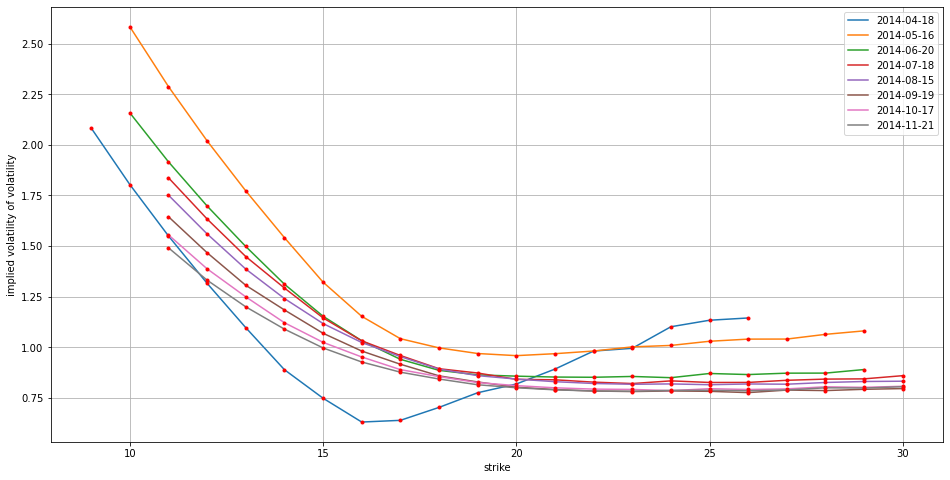

In [15]:
# 각 만기별로 시각화
# 변동성 스마일 현상을 볼 수 있음

import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(16, 8))
for maturity in maturities:
    data = plot_data[options_data.MATURITY == maturity]
      # select data for this maturity
    plt.plot(data['STRIKE'], data['IMP_VOL'], label=maturity.date(), lw=1.5)
    plt.plot(data['STRIKE'], data['IMP_VOL'], 'r.', label='')
plt.grid(True) 
plt.xlabel('strike')
plt.ylabel('implied volatility of volatility')
plt.legend()
plt.show()


In [17]:
# pandas 계층 인덱스
# 옵션 시장 가격 정보와, 만기, 행사가를 알면 하나의 옵션 선택 가능
# 따라서 만기와 행사가를 데이터 프레임의 새로운 인덱스로 설정

keep = ['PRICE', 'IMP_VOL']
group_data = plot_data.groupby(['MATURITY', 'STRIKE'])[keep]
print(group_data)
group_data = group_data.sum()

# 2계층 인덱스와 2개의 열을 가짐
print(group_data.index.levels)

group_data

[[2014-04-18 09:00:00, 2014-05-16 09:00:00, 2014-06-20 09:00:00, 2014-07-18 09:00:00, 2014-08-15 09:00:00, 2014-09-19 09:00:00, 2014-10-17 09:00:00, 2014-11-21 09:00:00], [9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0]]


PRICE   IMP_VOL
MATURITY            STRIKE                 
2014-04-18 09:00:00 9.0      8.85  2.083388
                    10.0     7.85  1.804193
                    11.0     6.85  1.550283
                    12.0     5.85  1.316103
                    13.0     4.85  1.097184
                    14.0     3.85  0.889581
                    15.0     2.90  0.748630
                    16.0     2.00  0.630958
                    17.0     1.35  0.639297
                    18.0     0.95  0.703208
                    19.0     0.70  0.775629
                    20.0     0.50  0.818813
                    21.0     0.40  0.892494
                    22.0     0.35  0.981551
                    23.0     0.25  0.995124
                    24.0     0.25  1.101613
                    25.0     0.20  1.133795
                    26.0     0.15  1.144977
2014-05-16 09:00:00 10.0     9.55  2.583783
                    11.0     8.55  2.287971
                    12.0     7.55  2.019846
                    13.0     6.55  1.772845
                    14.0     5.55  1.541737
                    15.0     4.55  1.321948
                    16.0     3.65  1.153127
                    17.0     2.90  1.042663
                    18.0     2.35  0.997287
                    19.0     1.90  0.969408
                    20.0     1.55  0.958881
                    21.0     1.30  0.968536
                    22.0     1.10  0.981696
                    23.0     0.95  1.002147
                    24.0     0.80  1.009341
                    25.0     0.70  1.029931
                    26.0     0.60  1.040552
                    27.0     0.50  1.040786
                    28.0     0.45  1.064116
                    29.0     0.40  1.081293
2014-06-20 09:00:00 10.0     9.95  2.158263
                    11.0     8.95  1.916282
                    12.0     7.95  1.698137
                    13.0     6.95  1.498164
                    14.0     5.95  1.311953
                    15.0     5.00  1.153564
                    16.0     4.15  1.032755
                    17.0     3.40  0.940780
                    18.0     2.80  0.886235
                    19.0     2.35  0.863944
                    20.0     2.00  0.857611
                    21.0     1.70  0.853162
                    22.0     1.45  0.852049
                    23.0     1.25  0.856096
                    24.0     1.05  0.850040
                    25.0     0.95  0.870737
                    26.0     0.80  0.865472
                    27.0     0.70  0.872362
                    28.0     0.60  0.872663
                    29.0     0.55  0.890314
2014-07-18 09:00:00 11.0     9.40  1.837558
                    12.0     8.40  1.633950
                    13.0     7.40  1.448368
                    14.0     6.45  1.292919
                    15.0     5.50  1.145486
                    16.0     4.65  1.032220
                    17.0     3.95  0.959642
                    18.0     3.30  0.894344
                    19.0     2.85  0.873128
                    20.0     2.40  0.841792
                    21.0     2.10  0.839546
                    22.0     1.80  0.828006
                    23.0     1.55  0.821050
                    24.0     1.40  0.834280
                    25.0     1.20  0.826374
                    26.0     1.05  0.826605
                    27.0     0.95  0.837122
                    28.0     0.85  0.842999
                    29.0     0.75  0.844207
                    30.0     0.70  0.859997
2014-08-15 09:00:00 11.0     9.70  1.751569
                    12.0     8.70  1.560281
                    13.0     7.70  1.386624
                    14.0     6.75  1.241100
                    15.0     5.85  1.117474
                    16.0     5.05  1.023800
                    17.0     4.35  0.954201
                    18.0     3.70  0.892497
                    19.0     3.20  0.860103
                    20.0     2.80  0.843280
                    21.0     2.45  0.830238
                    22.0